<a href="https://colab.research.google.com/github/componavt/sns4human/blob/main/src/vk/nlp/scikit_LDA_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# topics are indicated by an expert for each social network post
filename = '512_posts_24_topics.csv'

# the number of topics the Latent Dirichlet Allocation (LDA) model must extract from the set of documents
n_components = 24

# объём тестовой выборки, test_size=0.2 (20% test, 80% evaluation)
# test_size=0.2
test_size=0.01 # почти все посты идут на обучение LDA и рисование графа

# using threshold per predicted topic (in Graph Step 3: adding edges)
threshold = 0.17
#threshold = 0.23
#threshold = 0.30
# threshold = 0.38 0.35


In [32]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
!pip install -U pymorphy3
import pymorphy3
import requests
import csv
import gzip
import shutil

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.corpus import stopwords
stop_words = stopwords.words("russian")

#stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/RussianStopWords.txt').text.split('\n')
#stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/stopwords-ru.txt').text.split()
alphabet = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя')
alphabet_dash = alphabet | {'-'}# alphabet + dash

morph = pymorphy3.MorphAnalyzer(lang='ru')

from io import StringIO
response = requests.get(f'https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/data/vk/topics/{filename}')
df = pd.read_csv(StringIO(response.text), delimiter=',', encoding='utf-8')
print(df.index.name)

None


In [33]:
def get_text_window(words, index, window_size=3):
    """Returns a context window of words around the given index."""
    start = max(0, index - window_size)
    end = min(len(words), index + window_size + 1)
    return ' '.join(words[start:end])

def contains_non_dash(s):
    """Check if a string consists not only dash characters."""
    return s.count('-') < len(s)

def process_text(text):
    sentences = sent_tokenize(text)  # Split into sentences
    processed_sentences = []

    for sentence in sentences:
        check_hash = False
        processed_parts = []
        words = word_tokenize(sentence)

        for i, w in enumerate(words):
          if len(w) == 1:
            continue
          if w == '#':
            check_hash = True
            continue
          if check_hash:
            check_hash = False
            continue

          # skip name and surname
          # w_tag = morph.parse(w.strip())[0].tag
          #if 'Surn' in w_tag or 'Name' in w_tag or 'Patr' in w_tag:
          #  context = get_text_window(words, i)
          #  print(f"Filtered name/surname: {w} | Context: {context}")  # Debug output for context
          #  continue

          if set(w.lower()).issubset(alphabet_dash) and contains_non_dash(w):
            res = morph.parse(w.lower())[0].normal_form
            if res and (res not in stop_words):
                  processed_parts.append(res)
          else:
            # has 4+ Cyrillic characters then will parse too (e.g. блж.Фаддея о.Алексия г.Петрозаводске)
            if sum(1 for char in w.lower() if char in alphabet) >= 4:
              if ('\\' not in w) and ('/' not in w): # skip words-hyperlinks
                #context = get_text_window(words, i)
                #print(f"Filtered not subset(alphabet): {w} | Context: {context}")
                res = morph.parse(w.lower())[0].normal_form
                if res not in stop_words:
                  processed_parts.append(res)

        if processed_parts:
            last_word = processed_parts[-1]
            if last_word[-1] not in ".!?":
                #processed_parts.append(".")  # Add period at the end of sentence
                processed_parts[-1] += "."    # Attach period directly to the last word

        processed_sentences.append(" ".join(processed_parts))

    return " ".join(processed_sentences).strip()

In [34]:
!pip install pymorphy3
import pymorphy3
morph = pymorphy3.MorphAnalyzer(lang='ru')

for index, row in df.iterrows():
    text = row['text'].lower()
    df.loc[index, 'normalized'] = process_text(row['text'])  # .lower())

In [35]:
from sklearn.model_selection import train_test_split
train_docs, test_docs = train_test_split(df, test_size=test_size, random_state=42, shuffle=True)

unique_topics = sorted(train_docs['topic'].unique())  # sort topics by name
#print(f"Total topics: {len(unique_topics)}")
#for i, topic in enumerate(unique_topics, 1):  # print from 1
#    print(f"{i}. {topic}")

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create TF-IDF matrix
#vectorizer = TfidfVectorizer(max_df=.2, min_df=3, max_features=2000)
# TODO: CountVectorizer лучше?
vectorizer = CountVectorizer(
#vectorizer = TfidfVectorizer(
    max_df=0.8,        # Игнорировать слишком частые слова (в >80% документов)
    min_df=2,          # Игнорировать слова, встречающиеся только один раз
    max_features=1000, # Умеренное количество признаков
#    stop_words=stop_words,  # уже убрали
)

# Transform text into TF-IDF matrix
doc_train_matrix = vectorizer.fit_transform(train_docs['normalized'])
doc_test_matrix = vectorizer.transform(test_docs['normalized'])

# Get feature names
words = vectorizer.get_feature_names_out()

# Generate topic labels
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components + 1)]

# Fit LDA model
lda = LatentDirichletAllocation(
    n_components=n_components,
    n_jobs=-1,
    max_iter=77,
    learning_method='batch',
    evaluate_every=10,
    verbose=1,
    random_state=42
)
lda.fit(doc_train_matrix)


# Save and load the model
joblib.dump(lda, 'model.pkl')
lda = joblib.load('model.pkl')

# Compute topic-word probabilities
topics_count = lda.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)

# почему первый столбец - это названия группы в ВК (domain)?
topics.head()

iteration: 1 of max_iter: 77
iteration: 2 of max_iter: 77
iteration: 3 of max_iter: 77
iteration: 4 of max_iter: 77
iteration: 5 of max_iter: 77
iteration: 6 of max_iter: 77
iteration: 7 of max_iter: 77
iteration: 8 of max_iter: 77
iteration: 9 of max_iter: 77
iteration: 10 of max_iter: 77, perplexity: 712.2918
iteration: 11 of max_iter: 77
iteration: 12 of max_iter: 77
iteration: 13 of max_iter: 77
iteration: 14 of max_iter: 77
iteration: 15 of max_iter: 77
iteration: 16 of max_iter: 77
iteration: 17 of max_iter: 77
iteration: 18 of max_iter: 77
iteration: 19 of max_iter: 77
iteration: 20 of max_iter: 77, perplexity: 684.8215
iteration: 21 of max_iter: 77
iteration: 22 of max_iter: 77
iteration: 23 of max_iter: 77
iteration: 24 of max_iter: 77
iteration: 25 of max_iter: 77
iteration: 26 of max_iter: 77
iteration: 27 of max_iter: 77
iteration: 28 of max_iter: 77
iteration: 29 of max_iter: 77
iteration: 30 of max_iter: 77, perplexity: 677.8523
iteration: 31 of max_iter: 77
iteration: 32

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
100,0.000051,0.00012,0.000101,0.000026,0.000066,0.000059,0.000037,0.000039,0.004449,0.001006,...,0.003373,0.000029,0.000053,0.000049,0.000057,0.000053,0.000023,0.000059,0.000095,0.0001
100словокарелия,0.000051,0.00012,0.000101,0.000026,0.001842,0.000059,0.000037,0.000039,0.000061,0.000021,...,0.000028,0.000029,0.000053,0.000049,0.000057,0.000053,0.033731,0.000059,0.000095,0.0001
club147415188,0.000051,0.00012,0.000101,0.000026,0.000066,0.001467,0.000037,0.000039,0.000061,0.000021,...,0.000028,0.001598,0.000053,0.004399,0.000057,0.000053,0.000023,0.000059,0.000095,0.0001
club791498,0.011065,0.00012,0.000101,0.000026,0.000066,0.000059,0.000037,0.000039,0.000061,0.000021,...,0.000028,0.000029,0.000053,0.000049,0.000057,0.000053,0.000023,0.000059,0.000095,0.0001
cамый,0.000051,0.00012,0.000101,0.000026,0.000066,0.000059,0.000037,0.000039,0.000061,0.000021,...,0.000028,0.000029,0.000053,0.000049,0.000057,0.000053,0.012757,0.000059,0.000095,0.0001


In [37]:
# Extract top words per topic
n_words = 12
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(n_words).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
0,музей,вепс,карелия,конкурс,карел,рубль,музей,карельский,карелия,год,...,карелия,карелия,год,карелия,конкурс,день,пример,сказка,район,сегодня
1,карелия,карельский,родственник,республика,это,млн,история,это,наш,карелия,...,культура,выставка,который,республика,соус,год,слово,весь,петрозаводск,жить
2,это,который,гость,год,карельский,программа,выставка,народный,место,это,...,народный,карельский,водопад,карельский,жюри,праздник,свой,русский,вопрос,остаться
3,ночь,народ,работа,культура,слово,год,свой,концерт,вода,наш,...,республика,рубль,ещё,вепсский,зима,весь,100словокарелия,карелия,дом,новый
4,национальный,сеть,фестиваль,карелия,олень,санкт,который,традиция,это,карельский,...,песня,национальный,время,язык,работа,наш,конец,всё,новый,электронный
5,национальныймузейкарелия,вепсский,пудожский,центр,весь,петербург,семья,хор,то,весь,...,коллектив,мастер,традиционный,народ,участник,ноябрь,стена,сборник,это,александр
6,день,язык,республика,участие,карелия,средство,наш,который,зерно,паккайн,...,хор,республика,карелия,мероприятие,мастер,народный,опубликовать,год,карелов,иванович
7,который,отчёт,приглашать,проект,знать,местный,карелия,год,кто,тверской,...,музыкальный,билет,это,семинар,кухня,желать,язык,печка,прионежский,свой
8,пусть,костюм,карельский,общественный,всё,поддержка,человек,день,музей,который,...,творчество,проект,человек,коренной,проведение,карелия,ответ,это,запись,название
9,всё,организация,программа,россия,день,наш,ребёнок,детский,предлагать,свой,...,наш,класс,начало,вопрос,заезд,отмечать,неделя,новый,улица,исторический


In [38]:
# Predict topic distribution for training data
train_preds = lda.transform(doc_train_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)

# Prepare topic assignment per document
df = train_eval.groupby(level='topic').idxmax(axis=1).reset_index(drop=True)
#topic_pred = train_eval.idxmax(axis=1) # Get the topic with the highest probability for each document
#df = topic_pred.groupby(train_eval.index).value_counts(normalize=True).unstack(fill_value=0) # Group by true topic and count predictions


<ipython-input-38-b115e5e76e15>:6: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(axis=1).reset_index(drop=True)


Text(0.5, 1.0, 'Training: Topic Distribution')

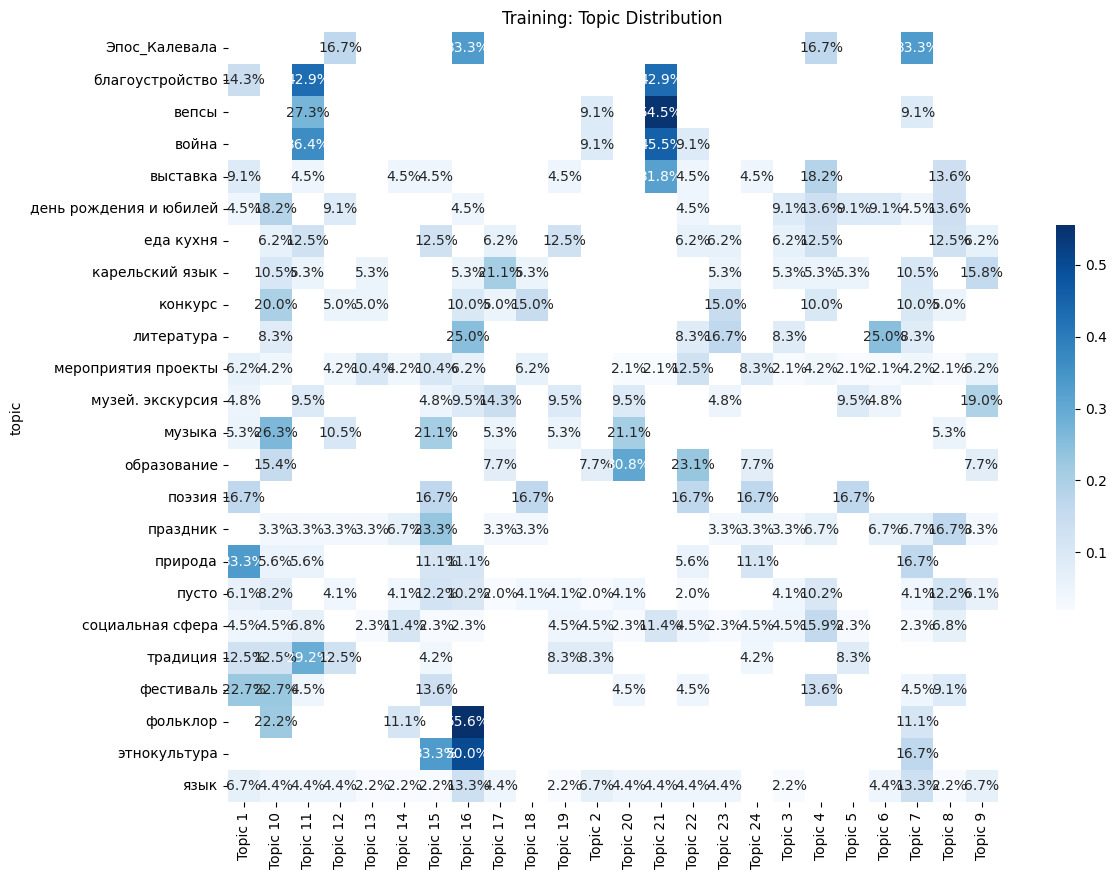

In [39]:
# Plot heatmap of topic distribution
plt.figure(figsize=(15, 10))
sns.heatmap(
    df.groupby(train_docs.topic).value_counts(normalize=True).unstack(-1),
    annot=True,
    fmt='.1%',
    cmap='Blues',
    square=True,
    cbar_kws={"shrink": 0.5}
)
plt.title('Training: Topic Distribution')
#plt.title('Обучение: Тематики')

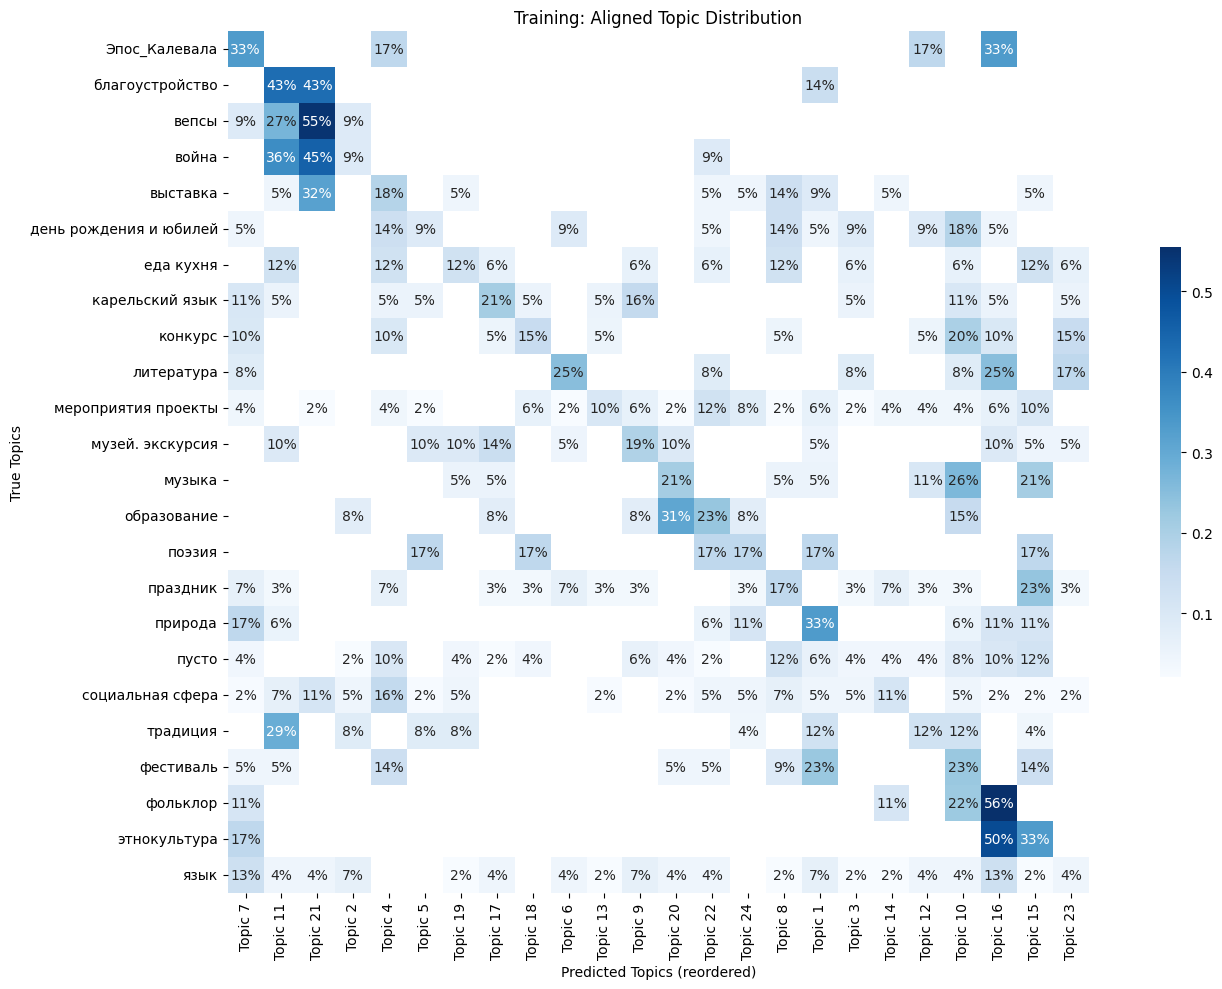

In [40]:
# Reorder topics for maximum alignment with true topics
confusion_matrix = df.groupby(train_docs.topic).value_counts(normalize=True).unstack(-1)

# Fill possible NaN values with zeros and convert to float
confusion_matrix = confusion_matrix.fillna(0).astype(float)

# Find the optimal assignment
from scipy.optimize import linear_sum_assignment
import numpy as np

try:
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix.values)
    ordered_topics = confusion_matrix.columns[col_ind[np.argsort(row_ind)]]

    # Create a mask for zero values
    mask = confusion_matrix.loc[confusion_matrix.index, ordered_topics] == 0

    plt.figure(figsize=(15, 10))
    sns.heatmap(
        confusion_matrix.loc[confusion_matrix.index, ordered_topics],
        annot=True,
        fmt='.0%',         # Display as '0%' (no decimal)
        cmap='Blues',
        square=True,
        mask=mask,         # Mask cells with zero value
        cbar_kws={"shrink": 0.5}
    )
    plt.title('Training: Aligned Topic Distribution')
    plt.ylabel('True Topics')
    plt.xlabel('Predicted Topics (reordered)')
    plt.tight_layout()

except ValueError as e:
    print(f"Error while processing the matrix: {e}")
    print("Matrix for verification:")
    print(confusion_matrix)
    print("Data types in the matrix:")
    print(confusion_matrix.dtypes)

True topics("карельский язык", "конкурс" и "традиция") тесно связаны между собой через Predicted topics (topic 1, >=17%).
True topics("карельский язык", "литература", "поэзия", "фестиваль" и "этнокультура") тесно связаны между собой через Predicted topics (topic 21, >=17%).
Задача визуализировать вершины графа (True topics), связать их между собой рёбрами, где вес ребра берётся из тех же данных, что и для рисования здесь тепловой карты.


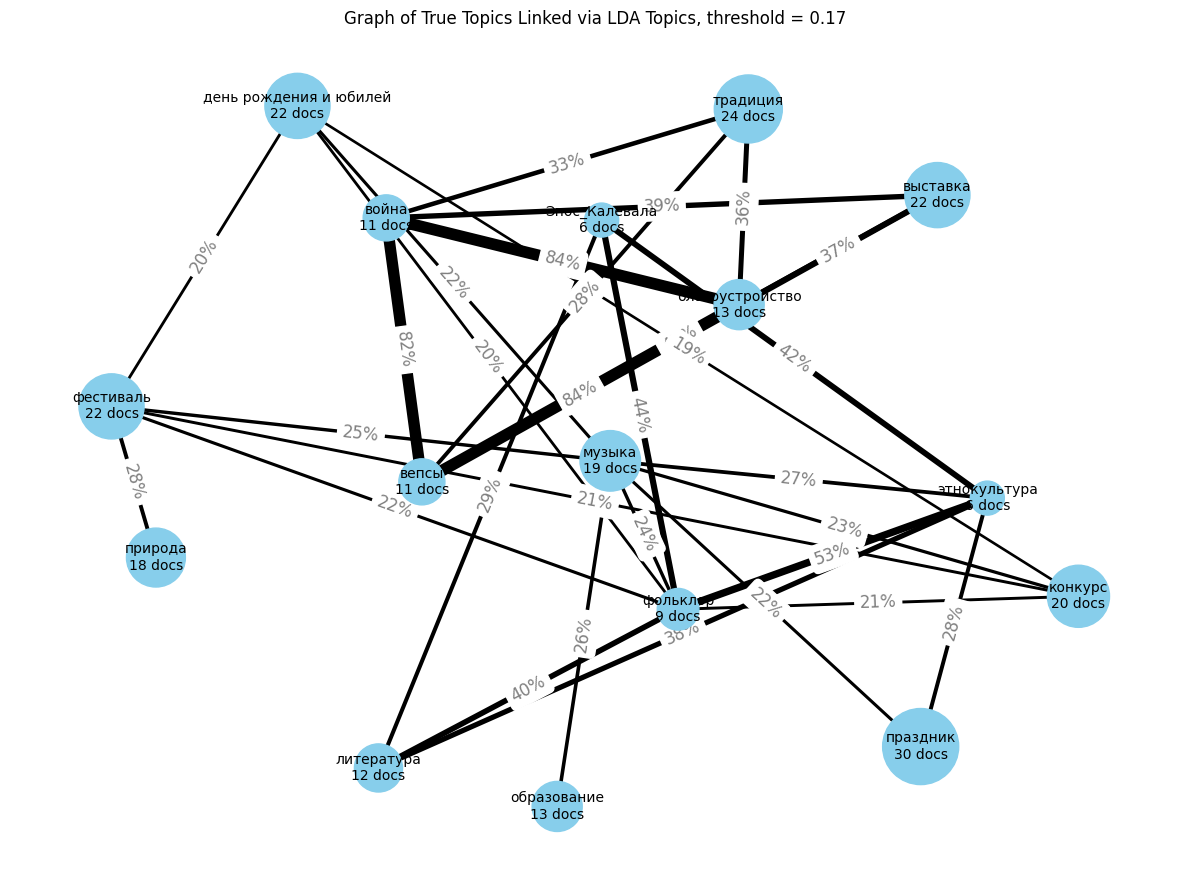

In [57]:
# Graph visualization of true topic relationships via shared LDA topics
import networkx as nx
import matplotlib.pyplot as plt

# Flag to control whether to keep only connected components or full graph
keep_only_connected = True

# Step 1: build the graph
G = nx.Graph()

# Step 2: add nodes with sizes (document count per topic)
doc_counts = train_docs['topic'].value_counts().to_dict()
for topic in confusion_matrix.index:
    G.add_node(topic, size=doc_counts.get(topic, 1))

# Step 3: add edges using threshold per predicted topic
# threshold = 0.23
for col in confusion_matrix.columns:
    related = confusion_matrix[confusion_matrix[col] >= threshold].index.tolist()
    for i in range(len(related)):
        for j in range(i + 1, len(related)):
            u, v = related[i], related[j]
            weight = (confusion_matrix.loc[u, col] + confusion_matrix.loc[v, col]) / 2
            if G.has_edge(u, v):
                G[u][v]['weight'] += weight
            else:
                G.add_edge(u, v, weight=weight)

# Step 4: choose graph to visualize
if keep_only_connected:
    components = [c for c in nx.connected_components(G) if len(c) > 1]
    G_sub = G.subgraph(set().union(*components)).copy()
else:
    G_sub = G.copy()

# Step 5: visualize the graph, k=1.5 - scale of distance between nodes
pos = nx.spring_layout(G_sub, seed=42, k=1.5)
node_sizes = [G_sub.nodes[n]['size'] * 100 for n in G_sub.nodes]

plt.figure(figsize=(12, 9))

nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, node_color='skyblue')

labels = {n: f"{n}\n{G_sub.nodes[n]['size']} docs" for n in G_sub.nodes}
nx.draw_networkx_labels(G_sub, pos, labels=labels, font_size=10)

edges = G_sub.edges(data=True)

weights = [d['weight'] * 10 for (_, _, d) in edges]
nx.draw_networkx_edges(G_sub, pos, width=weights)

edge_labels = {(u, v): f"{d['weight']*100:.0f}%" for u, v, d in edges}
nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=edge_labels, font_color='gray', font_size=12)

plt.axis('off')
plt.title("Graph of True Topics Linked via LDA Topics, threshold = "+str(threshold))
plt.tight_layout()
plt.show()

Вторая часть марлезонского балета

Accuracy on the test set: 0.00%


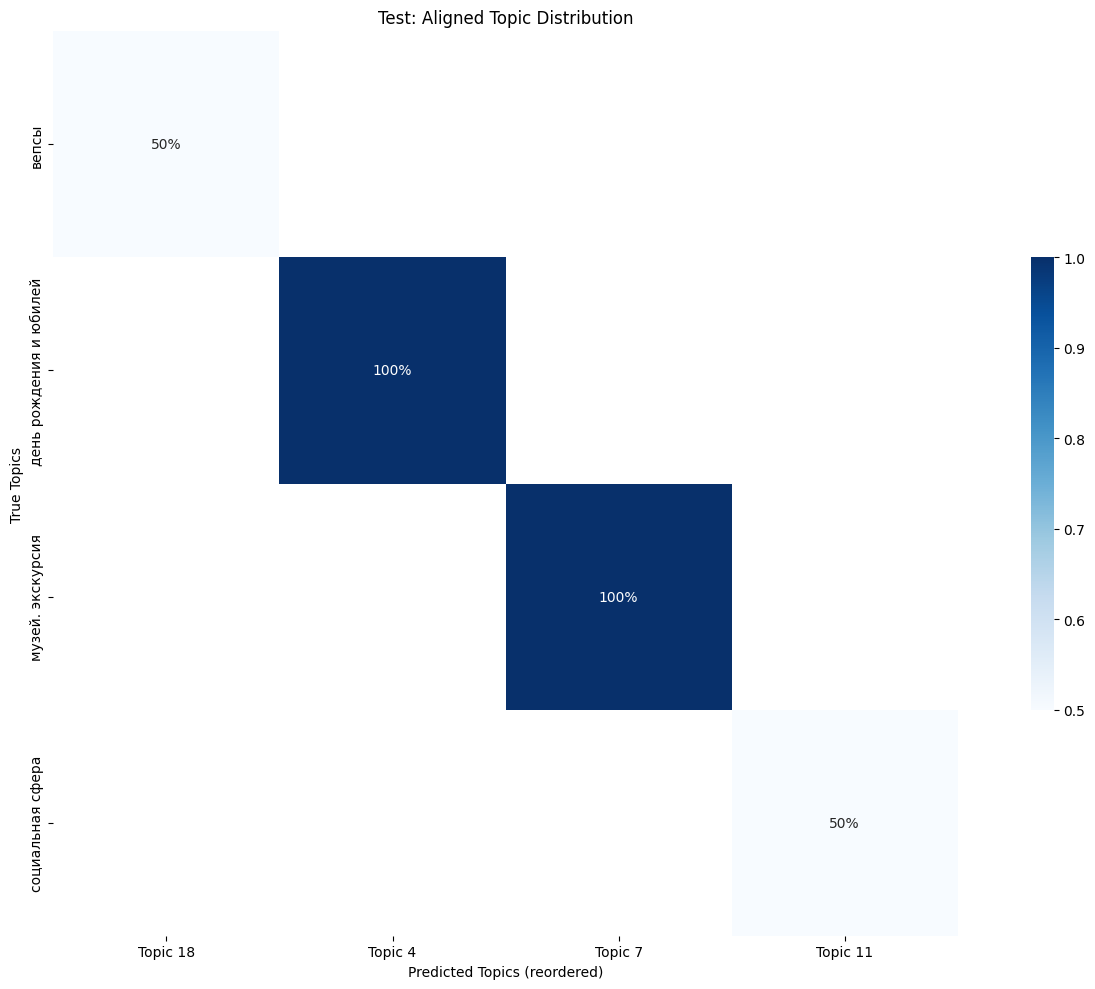

In [42]:
# Evaluation on the test set (second part of the file)

# Create DataFrames for predicted topic distributions (train and test)
train_eval = pd.DataFrame(data=lda.transform(doc_train_matrix),
                          columns=topic_labels,
                          index=train_docs.topic)

test_eval = pd.DataFrame(data=lda.transform(doc_test_matrix),
                         columns=topic_labels,
                         index=test_docs.topic)

# Predict topic with the highest probability for each test document
# Save it to a DataFrame together with the original text
test_assignments = (
    test_eval.idxmax(axis=1)  # Predicted topic (with highest probability)
    .to_frame(name='predicted')
    .reset_index()            # Restore true topic as a column
)
test_assignments['text'] = test_docs.text.values

# Compute confusion matrix: how predicted topics match true topics
conf_matrix = test_assignments.groupby(['topic', 'predicted']).size().unstack(fill_value=0)
conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)  # Normalize by rows

# Reorder predicted topics to better match true ones
from scipy.optimize import linear_sum_assignment
import numpy as np

try:
    row_ind, col_ind = linear_sum_assignment(-conf_matrix.values)
    ordered_predicted = conf_matrix.columns[col_ind[np.argsort(row_ind)]]

    # Create a mask for zero values (True means "mask this cell")
    mask = conf_matrix.loc[conf_matrix.index, ordered_predicted] == 0

    plt.figure(figsize=(15, 10))
    sns.heatmap(
        conf_matrix.loc[conf_matrix.index, ordered_predicted],
        annot=True,
        fmt='.0%',         # Display as '0%' (no decimal)
        cmap='Blues',
        square=True,
        mask=mask,         # Mask cells with zero value
        cbar_kws={"shrink": 0.5}
    )
    plt.title('Test: Aligned Topic Distribution')
    plt.ylabel('True Topics')
    plt.xlabel('Predicted Topics (reordered)')
    plt.tight_layout()

except ValueError as e:
    print(f"Error while building heatmap: {e}")
    print(conf_matrix)

# Compute classification accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_assignments['topic'], test_assignments['predicted'])
print(f"Accuracy on the test set: {accuracy:.2%}")

# Save predictions for the topic 'война'
war_assignments = test_assignments[test_assignments['topic'] == 'война']
war_assignments.to_csv("war.csv", index=False)

# Save all predictions
test_assignments.to_csv("res.csv", index=False)